In [1]:
# use image: dimension_reduction_benchmark

In [1]:
import scib_metrics
scib_metrics.__version__

'0.3.3'

In [2]:
import time 
import warnings
warnings.filterwarnings("ignore")
from numpy import * 
from scipy.sparse import *  
import anndata 
import pandas as pd
import scanpy as sc 
import snapatac2 as snap    
import scipy as sp   
import anndata as ad 
import numpy as np
from scipy.sparse.linalg import eigs
import os
rd = np.random.RandomState(888) 
import sys
sys.path.append('/data/work/')  
from method.scBiMapping import * 
import scib_metrics
from sklearn.metrics import adjusted_rand_score, silhouette_score, adjusted_mutual_info_score


In [3]:
snap.__version__

'2.3.1'

In [13]:
methods_all = ['SIMBA']

path = '/data/work/test_data'
dir_out = '/data/work/embedding_results/'
files = ['10x_Brain5k.h5ad','10x_PBMC10k.h5ad','Buenrostro_2018.h5ad','Chen_NBT_2019.h5ad','GSE194122_subset.h5ad','Ma_Cell_2020.h5ad','Trevino_Cell_2021.h5ad','Yao_Nature_2021.h5ad', 'Zemke_2023_human_subset.h5ad', 'Zemke_2023_mouse.h5ad']
files = ['10x_Brain5k.h5ad','10x_PBMC10k.h5ad','Buenrostro_2018.h5ad','Chen_NBT_2019.h5ad','GSE194122_subset.h5ad','Ma_Cell_2020.h5ad','Trevino_Cell_2021.h5ad','Yao_Nature_2021.h5ad', 'Zemke_2023_human_subset.h5ad'] 

In [14]:
def evalute(dir_out,method,dataName,cell_anno):
    embedding = np.genfromtxt(
    dir_out + method + dataName + "reduced_dim.tsv",
    missing_values="NA",
    filling_values = np.nan)

    umap = snap.tl.umap(embedding, n_comps=3, inplace=False)

    knn_50 = snap.pp.knn(embedding, n_neighbors=50, method="exact", inplace=False)
    knn_90 = snap.pp.knn(embedding, n_neighbors=90, method="exact", inplace=False)
 
    n_cluster = np.unique(cell_anno).size
    prev_n = -100
    prev_clusters = None
    for i in np.arange(0.1, 3, 0.1):
        clusters = snap.tl.leiden(knn_50, resolution=i, inplace=False)
        n = np.unique(clusters).size
        if n == n_cluster:
            break
        elif n > n_cluster:
            if n - n_cluster < n_cluster - prev_n:
                break
            else:
                clusters = prev_clusters
                break
        else:
            prev_clusters = clusters
            prev_n = n

    
    if knn_50.data.min() == 0:
        knn_50.data = knn_50.data + 1e-6
    if knn_90.data.min() == 0:
        knn_90.data = knn_90.data + 1e-6

    metrics = {}
    metrics["ARI"] = float(adjusted_rand_score(clusters, cell_anno))
    metrics["AMI"] = float(adjusted_mutual_info_score(clusters, cell_anno))
    metrics["Cell_type_ASW"] = scib_metrics.silhouette_label(umap, cell_anno)
    metrics['cLISI'] = float(np.median(scib_metrics.clisi_knn(knn_90, cell_anno)))
 
    return metrics


In [15]:
for method in methods_all:
    dicts = []
    for dataName in files: 
        print(method,dataName)
        adata = anndata.read(path+'/'+dataName) 
        cell_anno = adata.obs["cell_annotation"]
        metric = evalute(dir_out,method,dataName,cell_anno)
        metric['dataset'] = dataName
        metric['algorithm'] = method
        metric['group'] = 'main'
        dicts.append(metric)
    print(dicts)
    # pd.DataFrame(dicts).to_csv("/data/work/"+method+"metricsATAC.tsv", sep="\t", index=False, header=True)

SIMBA 10x_Brain5k.h5ad
SIMBA 10x_PBMC10k.h5ad
SIMBA Buenrostro_2018.h5ad
SIMBA Chen_NBT_2019.h5ad
SIMBA GSE194122_subset.h5ad
SIMBA Ma_Cell_2020.h5ad
SIMBA Trevino_Cell_2021.h5ad
SIMBA Yao_Nature_2021.h5ad
SIMBA Zemke_2023_human_subset.h5ad
[{'ARI': -0.001625908956042851, 'AMI': 0.0005180850017858758, 'Cell_type_ASW': 0.449603158980608, 'cLISI': 0.5978761249118381, 'dataset': '10x_Brain5k.h5ad', 'algorithm': 'SIMBA', 'group': 'main'}, {'ARI': -0.0002913882767946728, 'AMI': 0.0005879461367376944, 'Cell_type_ASW': 0.4125836342573166, 'cLISI': 0.7604672378963895, 'dataset': '10x_PBMC10k.h5ad', 'algorithm': 'SIMBA', 'group': 'main'}, {'ARI': 0.0019068175492165558, 'AMI': 0.0007190034652122468, 'Cell_type_ASW': 0.4697061516344547, 'cLISI': 0.5635882483588325, 'dataset': 'Buenrostro_2018.h5ad', 'algorithm': 'SIMBA', 'group': 'main'}, {'ARI': 0.0001712978806177188, 'AMI': -0.00010704383034503909, 'Cell_type_ASW': 0.433763325214386, 'cLISI': 0.7785059838067918, 'dataset': 'Chen_NBT_2019.h5ad',

In [16]:
pd.DataFrame(dicts).to_csv("/data/work/"+method+"metricsATAC.tsv", sep="\t", index=False, header=True)

import pandas as pd
all_data = pd.read_csv('/data/work/ATAC/12methods10scATAC4metrics.tsv', sep='\t') 
print(len(methods_all))
for method in methods_all:
    file_path = f"/data/work/{method}metricsATAC.tsv"  # 构建文件路径 
    data = pd.read_csv(file_path, sep='\t')  
    all_data = pd.concat([all_data, data], ignore_index=True)  # 追加数据
all_data.to_csv("/data/work/metricsATAC.tsv", sep="\t", index=False, header=True)

1


In [17]:
all_data

,ARI,AMI,Cell_type_ASW,cLISI,dataset,algorithm,group
0,0.659787,0.777351,0.778342,0.999410,10x_Brain5k.h5ad,SnapATAC2 (jaccard),main
1,0.501690,0.748472,0.696637,0.999828,10x_PBMC10k.h5ad,SnapATAC2 (jaccard),main
2,0.656683,0.722167,0.648934,0.985590,Buenrostro_2018.h5ad,SnapATAC2 (jaccard),main
3,0.379512,0.565823,0.566824,0.975797,Chen_NBT_2019.h5ad,SnapATAC2 (jaccard),main
4,0.334048,0.695901,0.631249,0.999758,GSE194122_subset.h5ad,SnapATAC2 (jaccard),main
...,...,...,...,...,...,...,...
124,0.002550,-0.000942,0.437291,0.828209,GSE194122_subset.h5ad,SIMBA,main
125,-0.000642,-0.000312,0.467441,0.766383,Ma_Cell_2020.h5ad,SIMBA,main
126,-0.000289,-0.000210,0.473331,0.649098,Trevino_Cell_2021.h5ad,SIMBA,main
127,-0.000676,-0.000095,0.493719,0.693819,Yao_Nature_2021.h5ad,SIMBA,main


In [18]:
all_data[all_data['algorithm']=='SIMBA']

,ARI,AMI,Cell_type_ASW,cLISI,dataset,algorithm,group
120,-0.001626,0.000518,0.449603,0.597876,10x_Brain5k.h5ad,SIMBA,main
121,-0.000291,0.000588,0.412584,0.760467,10x_PBMC10k.h5ad,SIMBA,main
122,0.001907,0.000719,0.469706,0.563588,Buenrostro_2018.h5ad,SIMBA,main
123,0.000171,-0.000107,0.433763,0.778506,Chen_NBT_2019.h5ad,SIMBA,main
124,0.002550,-0.000942,0.437291,0.828209,GSE194122_subset.h5ad,SIMBA,main
125,-0.000642,-0.000312,0.467441,0.766383,Ma_Cell_2020.h5ad,SIMBA,main
126,-0.000289,-0.000210,0.473331,0.649098,Trevino_Cell_2021.h5ad,SIMBA,main
127,-0.000676,-0.000095,0.493719,0.693819,Yao_Nature_2021.h5ad,SIMBA,main
128,-0.000083,-0.000122,0.462278,0.792292,Zemke_2023_human_subset.h5ad,SIMBA,main


In [19]:
file_path = f"/data/work/metricsATAC.tsv"  # 构建文件路径 
data = pd.read_csv(file_path, sep='\t')  

In [20]:
data

,ARI,AMI,Cell_type_ASW,cLISI,dataset,algorithm,group
0,0.659787,0.777351,0.778342,0.999410,10x_Brain5k.h5ad,SnapATAC2 (jaccard),main
1,0.501690,0.748472,0.696637,0.999828,10x_PBMC10k.h5ad,SnapATAC2 (jaccard),main
2,0.656683,0.722167,0.648934,0.985590,Buenrostro_2018.h5ad,SnapATAC2 (jaccard),main
3,0.379512,0.565823,0.566824,0.975797,Chen_NBT_2019.h5ad,SnapATAC2 (jaccard),main
4,0.334048,0.695901,0.631249,0.999758,GSE194122_subset.h5ad,SnapATAC2 (jaccard),main
...,...,...,...,...,...,...,...
124,0.002550,-0.000942,0.437291,0.828209,GSE194122_subset.h5ad,SIMBA,main
125,-0.000642,-0.000312,0.467441,0.766383,Ma_Cell_2020.h5ad,SIMBA,main
126,-0.000289,-0.000210,0.473331,0.649098,Trevino_Cell_2021.h5ad,SIMBA,main
127,-0.000676,-0.000095,0.493719,0.693819,Yao_Nature_2021.h5ad,SIMBA,main


dir_out: /data/work/metric_results/


2024-12-23 09:53:39 - WARNING - posx and posy should be finite values
2024-12-23 09:53:40 - WARNING - posx and posy should be finite values


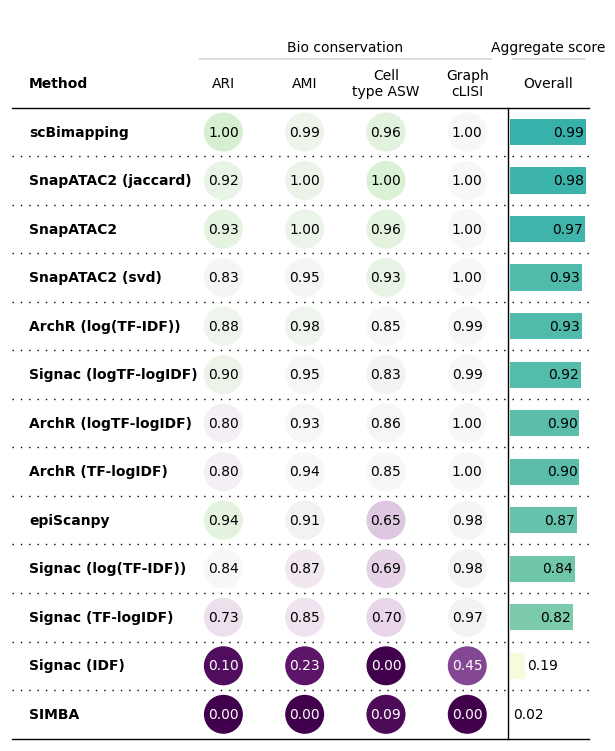

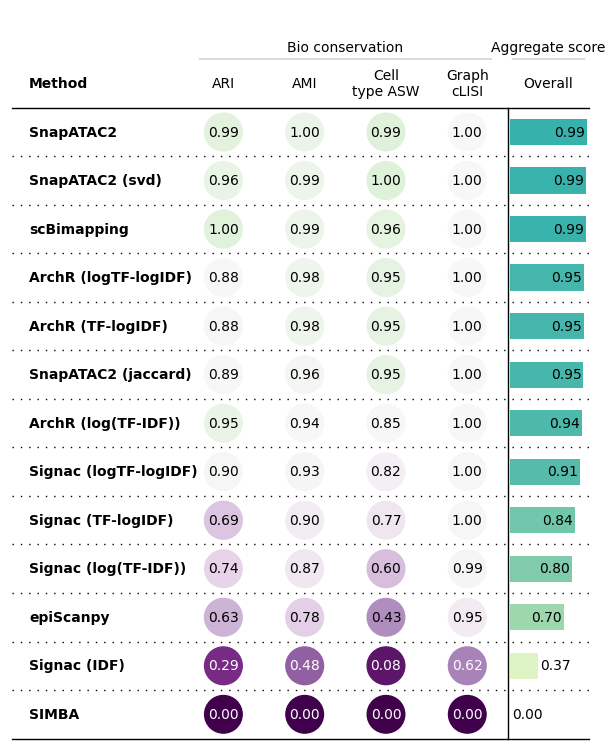

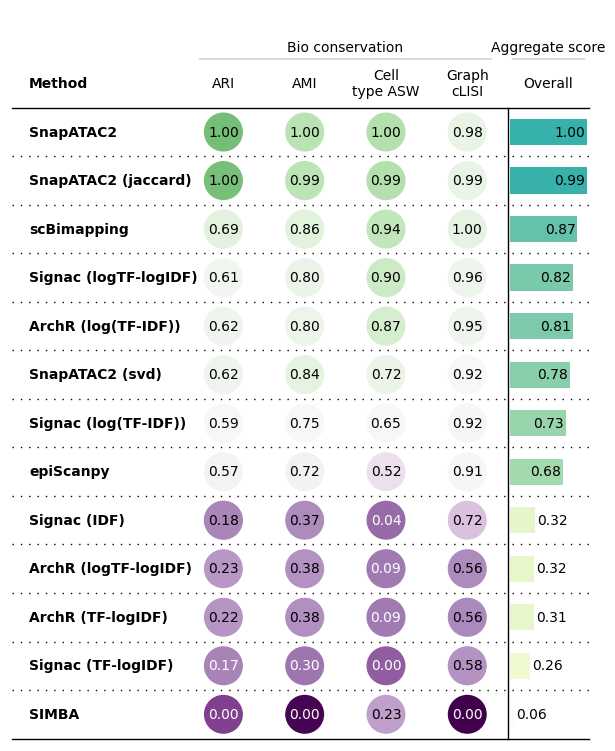

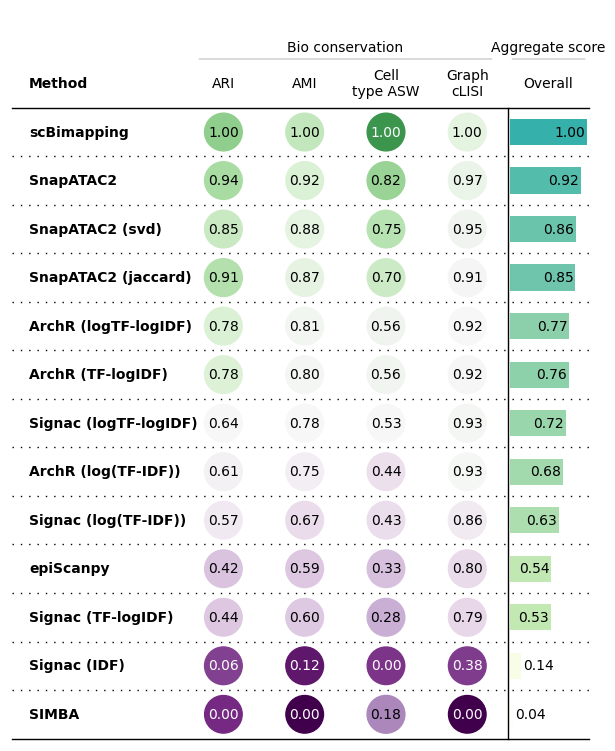

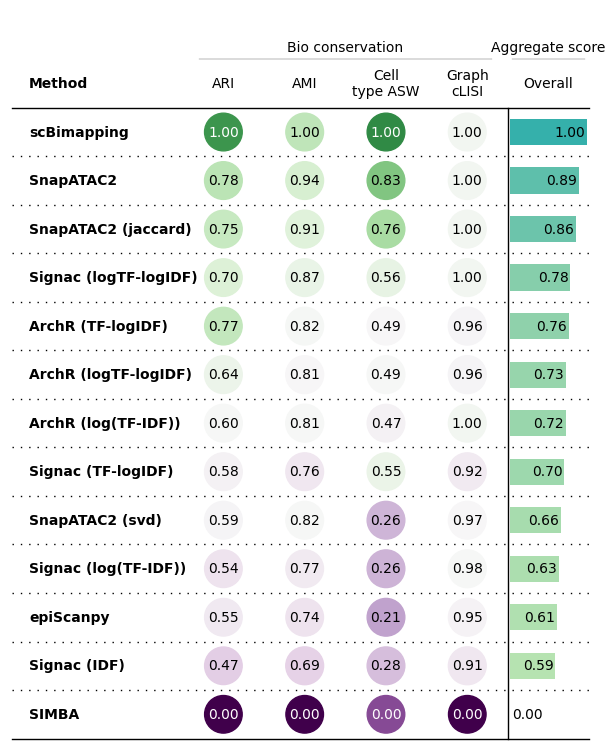

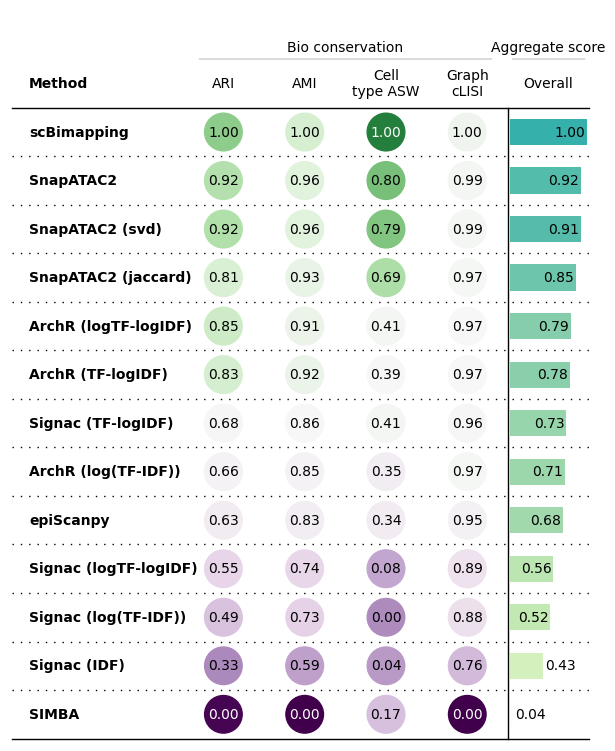

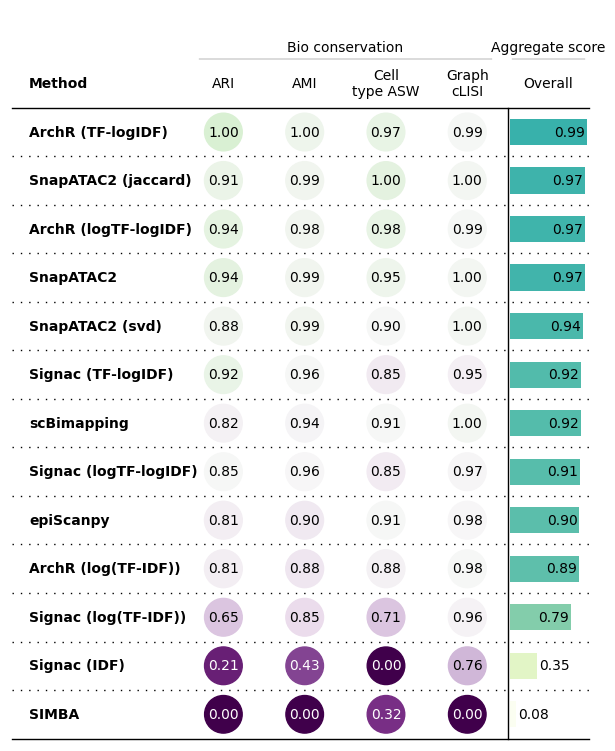

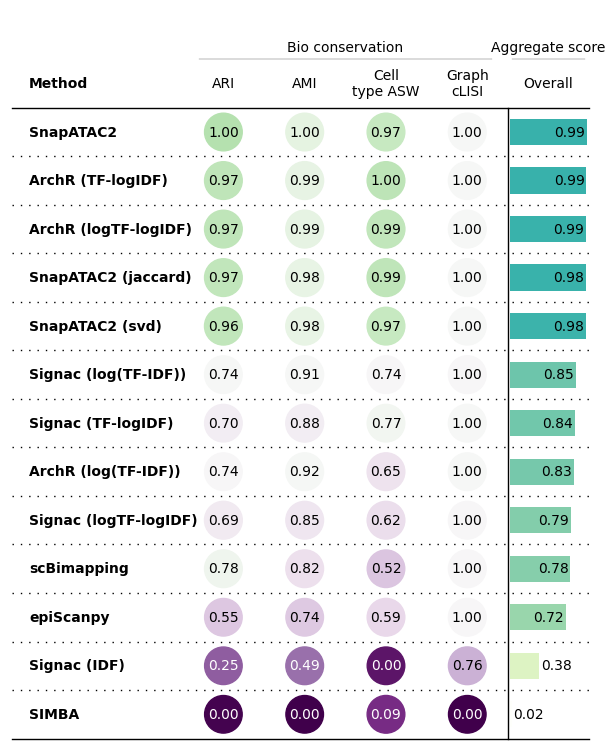

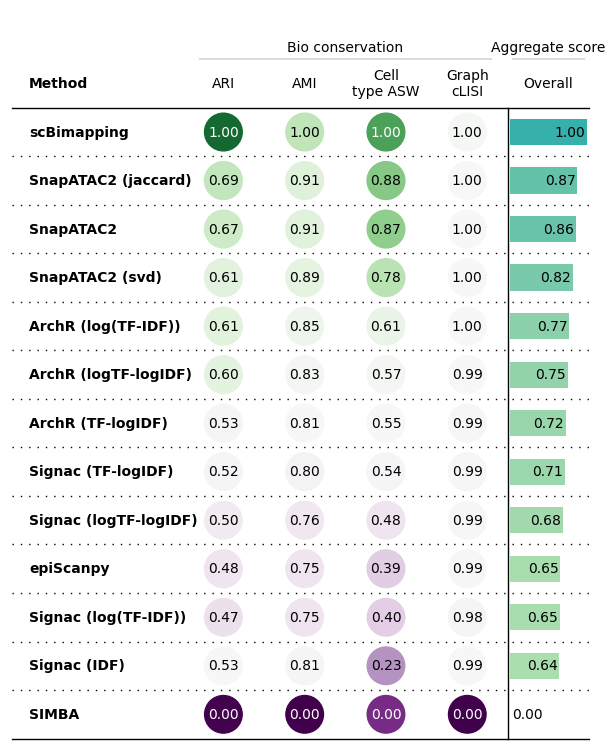

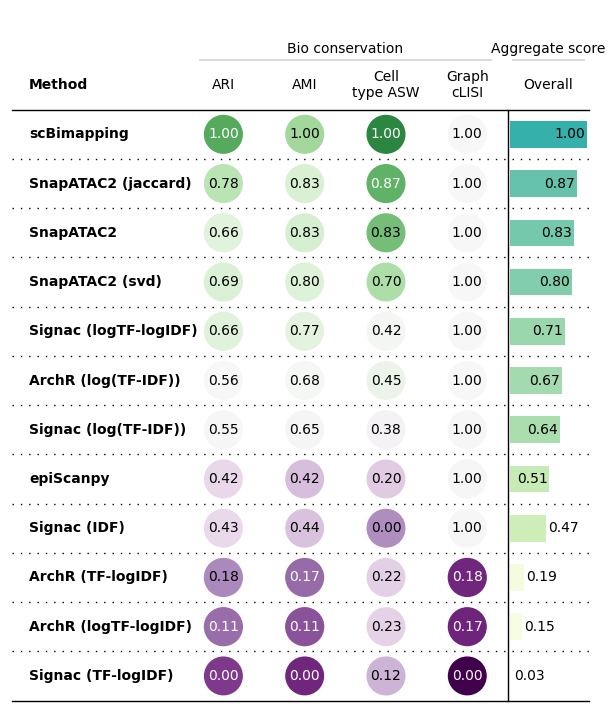

2024-12-23 09:53:42 - WARNING - posx and posy should be finite values
2024-12-23 09:53:43 - WARNING - posx and posy should be finite values


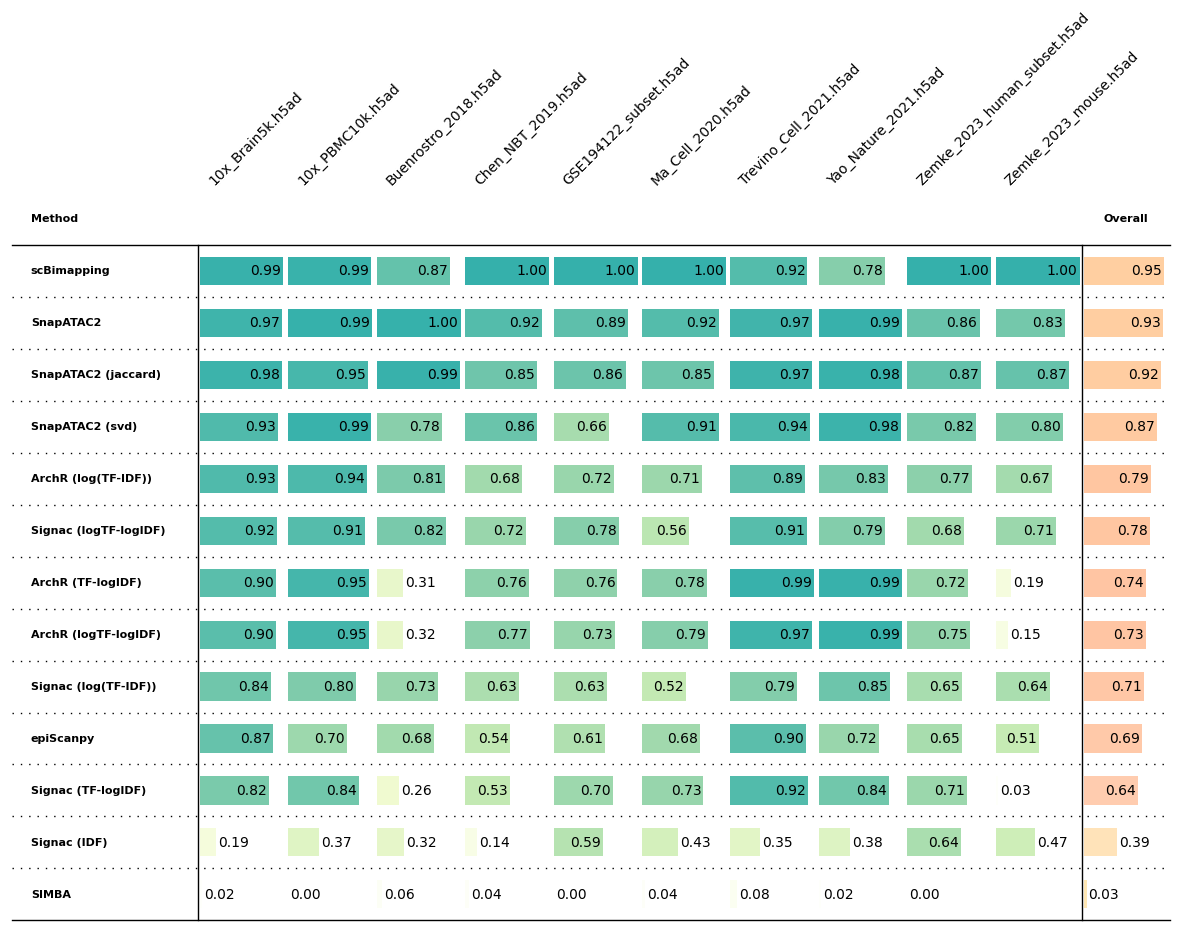

In [21]:
import os

# 获取当前工作目录
# current_directory = os.getcwd()
# print("当前工作目录是:", current_directory)

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from plottable import ColumnDefinition, ColDef, Table
from plottable.plots import bar
from plottable.cmap import normed_cmap
from matplotlib.colors import LinearSegmentedColormap
from sklearn.preprocessing import MinMaxScaler, StandardScaler

dir_out = '/data/work/metric_results/'
print(f'dir_out: {dir_out}')

df = pd.read_csv("/data/work/metricsATAC.tsv", sep="\t")                         
datasets = np.unique(df['dataset'])
 

cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)
summary = []
for name in datasets:
    plot_df = df[df['dataset'] == name]
    # remove columns that contain only NA values
    plot_df = plot_df.loc[:, plot_df.notna().any(axis=0)]

    # Perform scaling column-wise
    numeric_cols = plot_df.select_dtypes(include=['float64', 'int64']).columns
    min_max_scaler = MinMaxScaler()
    plot_df[numeric_cols] = min_max_scaler.fit_transform(plot_df[numeric_cols])

    aggregation_cols = []
    bio_conservation_cols = {
        "ARI": "ARI",
        "AMI": "AMI",
        "Cell_type_ASW": "Cell type ASW",                           #
        "cLISI": "Graph cLISI",                                    #
        "isolated_label_silhouette": "Isolated label silhouette",
    }
    bio_conservation_cols = {k : v for k, v in bio_conservation_cols.items() if k in plot_df.columns}
    if len(bio_conservation_cols) > 0:
        plot_df["Bio conservation"] = plot_df[list(bio_conservation_cols.keys())].mean(axis=1)
        aggregation_cols.append("Bio conservation")

    batch_correction_cols = {
        "Batch_ASW": "Batch ASW",
        "Graph_conn": "Graph connectivity",
        "kBET": "kBET",
        "iLISI": "Graph iLISI",
    }
    batch_correction_cols = {k: v for k, v in batch_correction_cols.items() if k in plot_df.columns}
    if len(batch_correction_cols) > 0:
        plot_df["Batch correction"] = plot_df[list(batch_correction_cols.keys())].mean(axis=1)
        aggregation_cols.append("Batch correction")

    if len(aggregation_cols) >= 2:
        plot_df["Overall"] = 0.6 * plot_df["Bio conservation"] + 0.4 * plot_df["Batch correction"]
        aggregation_cols.append("Overall")
    else:
        plot_df = plot_df.rename(columns={aggregation_cols[0]: "Overall"})
        aggregation_cols = ["Overall"]

    column_definitions = [
        ColumnDefinition(
            "algorithm",
            title="Method",
            width=plot_df["algorithm"].str.len().max() * 0.1,
            textprops={"ha": "left", "weight": "bold"}), 
    ]   

    column_definitions += [
        ColumnDefinition(
            col,
            width=1,
            title=title.replace(" ", "\n", 1),
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.25},
            },
            cmap=cmap_fn(plot_df[col]),
            group="Bio conservation",
            formatter="{:.2f}",
        )
        for col, title in bio_conservation_cols.items()
    ]
    column_definitions += [
        ColumnDefinition(
            col,
            width=1,
            title=title.replace(" ", "\n", 1),
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.25},
            },
            cmap=cmap_fn(plot_df[col]),
            group="Batch correction",
            formatter="{:.2f}",
        )
        for col, title in batch_correction_cols.items()
    ]
    column_definitions += [
        ColumnDefinition(
            col,
            width=1,
            title=col.replace(" ", "\n", 1),                
            plot_fn=bar,
            plot_kw={
                "cmap": LinearSegmentedColormap.from_list(
                    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
                ),
                "plot_bg_bar": False,
                "annotate": True,
                "height": 0.9,
                "formatter": "{:.2f}",
            },
            group="Aggregate score",
            border="left" if i == 0 else None,
        )
        for i, col in enumerate(aggregation_cols)
    ]

    summary.append(plot_df[["group", "algorithm", "dataset", "Overall"]].rename(columns={"Overall": "score"}))
    plot_df = ( plot_df[["algorithm"] +
                list(bio_conservation_cols.keys()) +
                list(batch_correction_cols.keys()) +
                aggregation_cols])
    plot_df = plot_df.sort_values(by="Overall", ascending=False)

    with matplotlib.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(figsize=(len(plot_df.columns) * 1.25, 3 + 0.5 * plot_df.shape[0]))
        tab = Table(
                plot_df,
                cell_kw={ 
                    "linewidth": 0,
                    "edgecolor": "k",
                },
                column_definitions=column_definitions,
                ax=ax,
                row_dividers=True,
                footer_divider=True, 
                textprops={"fontsize": 10, "ha": "center"},
                row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
                col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
                column_border_kw={"linewidth": 1, "linestyle": "-"},
                index_col="algorithm",
            ).autoset_fontcolors(colnames=plot_df.columns)
        fig.savefig(dir_out + name + ".pdf", facecolor=ax.get_facecolor(), bbox_inches='tight', pad_inches=0, dpi=300)
summary = pd.concat(summary)
for group in np.unique(summary['group']):
    plot_df = summary[summary['group'] == group]
    plot_df = plot_df.drop(columns=['group'])
    datasets = np.unique(plot_df['dataset'])
    plot_df = plot_df.pivot(index='algorithm', columns='dataset', values='score')
    plot_df['algorithm'] = plot_df.index
    plot_df['Overall'] = plot_df[datasets].mean(axis=1)
    plot_df = plot_df.sort_values(by="Overall", ascending=False)

    column_definitions = [
        ColumnDefinition(
            "algorithm",
            title="Method",
            width=plot_df["algorithm"].str.len().max() * 0.1,
            textprops={"ha": "left", "weight": "bold"}),
    ]

    column_definitions += [ 
        ColumnDefinition(
            col,
            width=1,
            #title=col.replace("", "\n", 1),   
            title = col,        
            textprops={
                    "rotation": 45,
                    "fontsize":10,                      
                    # "ha":"center", "va":"bottom",
                    "ha":"left", "va":"bottom",
                },
            plot_fn=bar,
            plot_kw={
                "cmap": LinearSegmentedColormap.from_list(
                    name="bugw", colors=["#ffffff", "#f2fbd2", "#c9ecb4", "#93d3ab", "#35b0ab"], N=256
                ),
                "plot_bg_bar": False,
                "annotate": True,  #
                "height": 0.9,
                "formatter": "{:.2f}",
            },
            # group="Dataset",
            group = None,
            border="left" if i == 0 else None,
            # border = None
        )
        for i, col in enumerate(datasets)
    ]

    column_definitions += [
        ColumnDefinition(
            "Overall",
            width=1,
            plot_fn=bar,
            textprops={"weight": "bold"},
            plot_kw={
                "cmap": LinearSegmentedColormap.from_list(
                    name="bugw", colors=["#FFE5B4", "#FFF3B0", "#FFD6C1", "#FFC4A1", "#FFD1A1"], N=256
                ),
                "plot_bg_bar": False,
                "annotate": True,
                "height": 0.9,
                "formatter": "{:.2f}",
            },
            border="left",
        )
    ]

    with matplotlib.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(figsize=(len(plot_df.columns) * 1.25, 3 + 0.5 * plot_df.shape[0]))  
        tab = Table(
                plot_df,
                cell_kw={
                    "linewidth": 0,
                    "edgecolor": "k",
                },
                column_definitions=column_definitions,
                ax=ax,
                row_dividers=True,
                footer_divider=True,
                textprops={"fontsize": 8, "ha": "center"},          # 10
                row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
                col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
                column_border_kw={"linewidth": 1, "linestyle": "-"},
                index_col="algorithm",
            ).autoset_fontcolors(colnames=plot_df.columns)
        fig.savefig(dir_out + group + "_summary.pdf", facecolor=ax.get_facecolor(), bbox_inches='tight', pad_inches=0, dpi=800)
plt.show()

In [ ]:
def umap(cell_anno,method_name,dataName,dr_path): 
    embedding = np.genfromtxt(
        dr_path+method_name+dataName+"reduced_dim.tsv",
        missing_values="NA",
        filling_values = np.nan,
    )
   
    umap = snap.tl.umap(embedding, inplace=False)

    umap = pd.DataFrame({
        "UMAP-1": umap[:, 0],
        "UMAP-2": umap[:, 1],
        "cell_type": cell_anno,
        "method": method_name,
    })
    print(umap)
    umap.to_csv(dr_path+method_name+dataName+"umap.tsv", sep="\t", index=False, header=True)

dir_out_umap = '/data/work/umap_results/'
for dataName in files:          
    for method in methods_all:
        adata = anndata.read(path+'/'+dataName) 
        cell_anno = adata.obs["cell_annotation"]
        umap(cell_anno,method,dataName,dir_out_umap)

In [ ]:
import snapatac2 as snap
import numpy as np
import pandas as pd
import json
from plotnine import *
import anndata as ad
import os
 
def output_all_umap(dr_path, datasetname, method_list, label="cell_type"):

    dfs = []
    for method_name in method_list:
        file_path = os.path.join(dr_path, dataName, f"{method_name}_umap.tsv")

        if not os.path.exists(file_path):
            print(f" {file_path} not exits, skipped")
            continue
        
        df = pd.read_csv(file_path, sep="\t")
        dfs.append(df)

    df = pd.concat(dfs, ignore_index=False)

    n_label = np.unique(np.array(list(map(str, df[label])))).size
    n = -(np.unique(df['method'].to_numpy()).size // -4)
    size = 0.1 if df.shape[0] > 20000 else 0.25

    (ggplot(df, aes(x='UMAP-1', y='UMAP-2', fill=label))
             + geom_point(size=size, raster=True, stroke=0)
             + facet_wrap('method', scales="free", ncol=4)
             + theme_light(base_size=7)
             + theme(
                 axis_ticks=element_blank(),
                 panel_grid_major=element_blank(),
                 panel_grid_minor=element_blank(),
                 figure_size=(1.7 * 4, 1.5 * n),
                 subplots_adjust={'hspace': 0.4, 'wspace': 0.2},
                 legend_key=element_rect(color="white"),
             )
             + guides(fill=guide_legend(override_aes={'size': 3}))
        ).save(f"umap_{datasetname}.pdf", dpi=800)


    print(f"save as umap_{datasetname}.pdf")

In [ ]:
for dataName in files: 
    output_all_umap(dir_out_umap, dataName, methods_all, label="cell_type")